## NO 2A

In [291]:
import os 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.optimizers import RMSprop

#### ambil semua path file gambar di folder

In [169]:
image_dir = 'B_23'

image_paths = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

#### liat total gambar

In [172]:
len(image_paths)

1074

Untuk memastikan dataset cukup besar untuk dibagi menjadi data training, validation, dan testing.

#### cek ukuran gambar pertama

In [176]:
sample_img = Image.open(image_paths[0])
sample_img.size

(600, 600)

Untuk mengetahui apakah semua gambar memiliki dimensi yang seragam. Ini penting karena model CNN memerlukan input dengan ukuran tetap, sehingga jika    tidak seragam maka akan dilakukan proses resize.

#### load contoh gambar

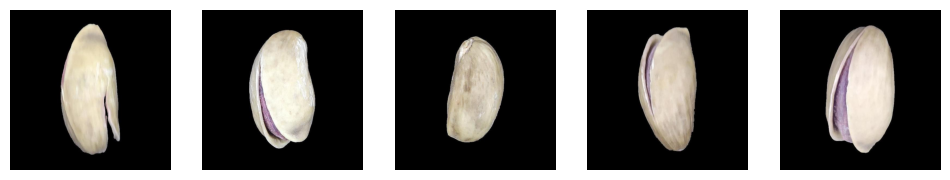

In [180]:
plt.figure(figsize=(12, 6))
for i, path in enumerate(image_paths[:5]):
    img = Image.open(path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Untuk memastikan gambar dalam folder dapat dibaca dengan baik, memiliki format yang valid (JPG/PNG), serta secara visual tampak bersih tanpa noise.

Informasi dari EDA ini membantu saya untuk menentukan preprocessing lanjutan seperti resize gambar ke 100x100, menambahkan noise, dan persiapan input model.

## 2B

#### baca dan resize seluruh gambar

In [186]:
images = []
for path in image_paths:
    img = Image.open(path).convert("RGB")        
    img = img.resize((100, 100))                 
    img_array = img_to_array(img) / 255.0        
    images.append(img_array)

images = np.array(images)
print("Jumlah gambar:", images.shape[0])
print("Ukuran tiap gambar:", images.shape[1:])

Jumlah gambar: 1074
Ukuran tiap gambar: (100, 100, 3)


load gambar dari folder, mengonversi ke format RGB, meresize ke ukuran 100x100 piksel, lalu mengubah ke array dan menormalkan piksel ke rentang 0–1. agar gambar punya ukuran dan skala yang seragam sebelum dimasukkan ke model.

#### split data

In [189]:
X_train, X_temp = train_test_split(images, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print("Train :", X_train.shape)
print("Val   :", X_val.shape)
print("Test  :", X_test.shape)

Train : (859, 100, 100, 3)
Val   : (107, 100, 100, 3)
Test  : (108, 100, 100, 3)


80% Train, 10% Val, 10% Test

#### tambah gaussian noise

In [192]:
def add_gaussian_noise(X, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0., 1.) 

X_train_noisy = add_gaussian_noise(X_train)
X_val_noisy   = add_gaussian_noise(X_val)
X_test_noisy  = add_gaussian_noise(X_test)

Fungsi untuk menambahkan noise Gaussian ke gambar asli. hasil akhirnya dipotong agar tetap di rentang 0–1.

#### visualisasi gambar asli vs noisy

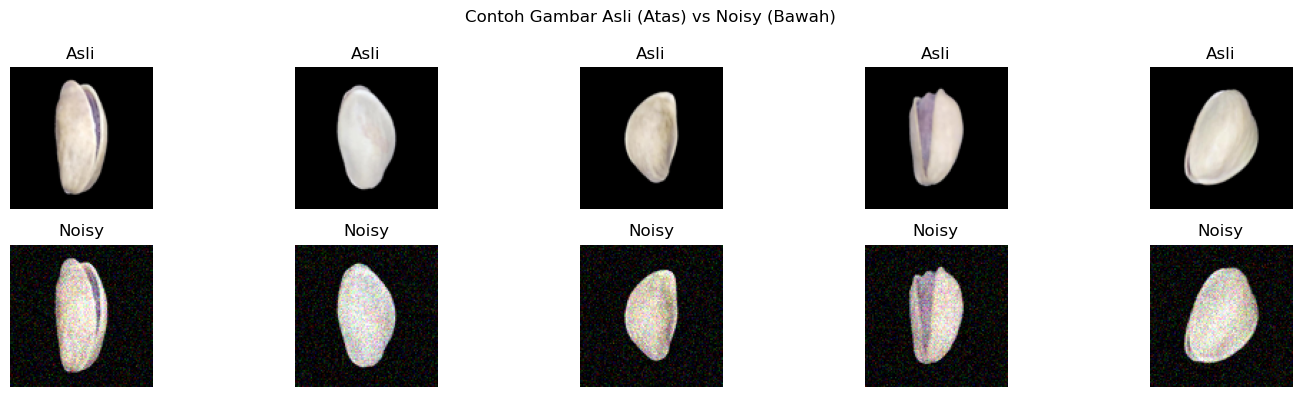

In [195]:
n = 5
plt.figure(figsize=(15, 4))
for i in range(n):
    # Asli
    plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i])
    plt.title("Asli")
    plt.axis("off")
    
    # Noisy
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_train_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

plt.suptitle("Contoh Gambar Asli (Atas) vs Noisy (Bawah)")
plt.tight_layout()
plt.show()

## 2c

### autoencoder baseline

##### input  layer

In [274]:
input_img = Input(shape=(100, 100, 3))

##### encoder

In [277]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x) 
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) 
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

##### Decoder

In [280]:
x = UpSampling2D((2, 2))(x) 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

##### Model

In [283]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

#### training autoencoder

In [286]:
history = autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=30,
    batch_size=32,
    shuffle=True
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step - loss: 0.1404 - val_loss: 0.0067
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 405ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 414ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 20

#### visualisasi hasil reconstruksi

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015F82031E40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step


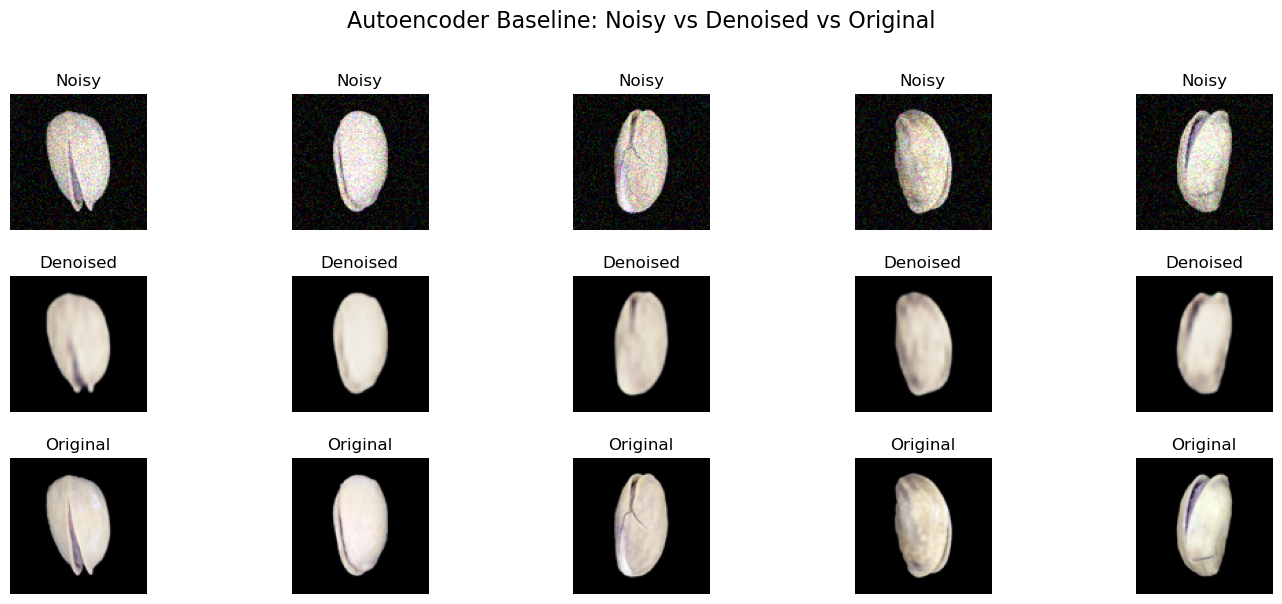

In [209]:
decoded_imgs = autoencoder.predict(X_test_noisy)

n = 5
plt.figure(figsize=(15, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(X_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout(pad=2.0) 
plt.suptitle("Autoencoder Baseline: Noisy vs Denoised vs Original", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.88)
plt.show()

## NO 2D

#### modifikasi auto encoder

##### modif model

In [293]:
autoencoder_mod = Sequential([
    Input(shape=(100, 100, 3)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.05), 

    Conv2D(64, (3, 3), activation='relu', padding='same'),

    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),

    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

menggunakan layer Conv2D dan MaxPooling2D lebih banyak dengan tambahan Dropout untuk mengurangi overfitting dan dengan BatchNormalization untuk mempercepat dan menstabilkan proses training. bagian decoder simetris dengan encoder, menggunakan UpSampling2D dan Conv2D, serta aktivasi sigmoid di output agar hasil rekonstruksi gambar berada di rentang 0-1.

##### compile model dengan  RMSprop dan learning rate kecil

In [297]:
autoencoder_mod.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

dicompile dengan optimizer adam dan learning rate 0.0005 agar training lebih stabil. loss yang digunakan MSE, dengan metrik MAE untuk evaluasi performa.

##### summary

In [301]:
autoencoder_mod.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 25, 25, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_16 (UpSampling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_17 (UpSampling2D)      │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,563 (1.35 MB)

 Trainable params: 353,923 (1.35 MB)

 Non-trainable params: 640 (2.50 KB)

#### training modifikasi

In [304]:
history_mod = autoencoder_mod.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=30,
    batch_size=32,
    shuffle=True
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 0.0474 - mae: 0.1381 - val_loss: 0.0708 - val_mae: 0.2458
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 0.0025 - mae: 0.0182 - val_loss: 0.0384 - val_mae: 0.1585
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 0.0017 - mae: 0.0149 - val_loss: 0.0411 - val_mae: 0.1452
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.0017 - mae: 0.0149 - val_loss: 0.0397 - val_mae: 0.1296
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 0.0015 - mae: 0.0136 - val_loss: 0.0344 - val_mae: 0.1123
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0012 - mae: 0.0125 - val_loss: 0.0334 - val_mae: 0.1035
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.0012 - mae: 0.0123 - val_loss: 0.0280 - val_mae: 0.0908
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0010 - mae: 0.0111 - val_loss: 0.0241 - val_mae: 0.0811
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.0011 - mae: 

#### visualisasi hasil model modifikasi

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step


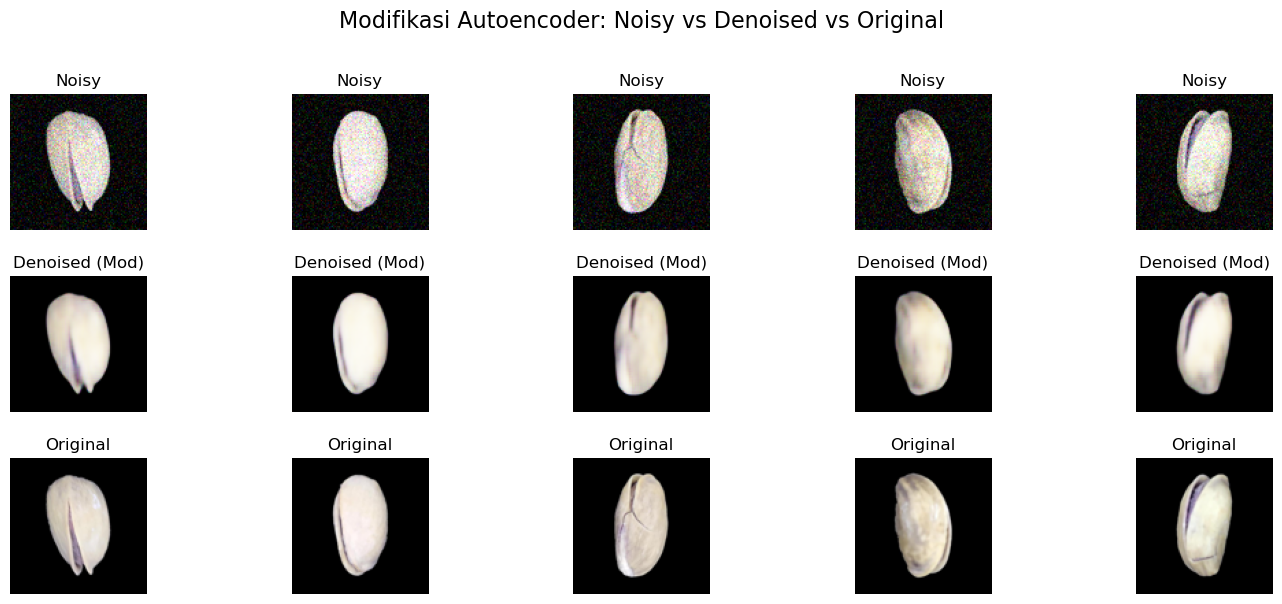

In [306]:
decoded_imgs_mod = autoencoder_mod.predict(X_test_noisy)

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(X_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_mod[i])
    plt.title("Denoised (Mod)")
    plt.axis("off")

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout(pad=2.0)
plt.suptitle("Modifikasi Autoencoder: Noisy vs Denoised vs Original", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.88)
plt.show()

## NO 2E

#### fungsi penghitung SSIM (untuk batch)

In [310]:
def calculate_ssim_batch(originals, denoised):
    scores = []
    for i in range(len(originals)):
        score = ssim(originals[i], denoised[i], channel_axis=-1, data_range=1.0)
        scores.append(score)
    return scores

menghitung nilai SSIM antara gambar asli dan hasil rekonstruksi. semakin tinggi SSIM, semakin mirip gambar hasil model dengan gambar asli

#### hitung SSIM untuk baseline dan modifikasi

In [314]:
decoded_imgs = autoencoder.predict(X_test_noisy)
ssim_baseline = calculate_ssim_batch(X_test, decoded_imgs)

decoded_imgs_mod = autoencoder_mod.predict(X_test_noisy)
ssim_modifikasi = calculate_ssim_batch(X_test, decoded_imgs_mod)

print("=== SSIM Evaluation ===")
print(f"Baseline Model     : {np.mean(ssim_baseline):.4f}")
print(f"Modifikasi Model   : {np.mean(ssim_modifikasi):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
=== SSIM Evaluation ===
Baseline Model     : 0.9498
Modifikasi Model   : 0.9557


##### analisa
nilai yang lebih mendekati 1 menunjukkan kualitas rekonstruksi yang lebih baik. Model baseline menghasilkan nilai SSIM sebesar 0.9498, sedangkan model modifikasi menghasilkan nilai yang lebih tinggi yaitu 0.9557. Hal ini menunjukkan bahwa model modifikasi mampu menghasilkan gambar yang lebih mirip dengan aslinya dibandingkan model baseline. Peningkatan ini disebabkan oleh beberapa faktor, antara lain penambahan jumlah lapisan konvolusi yang lebih dalam, penggunaan batch normalization untuk menstabilkan distribusi aktivasi, serta dropout untuk mengurangi overfitting. Selain itu, model modifikasi juga menggunakan optimizer RMSprop dengan learning rate yang lebih kecil, sehingga proses pelatihan menjadi lebih halus dan stabil. Kombinasi elemen-elemen ini membuat model modifikasi mampu mempelajari representasi data yang lebih baik dan menghasilkan gambar hasil denoising yang lebih akurat.

## link video:

https://youtu.be/E5XPMHHRgVg

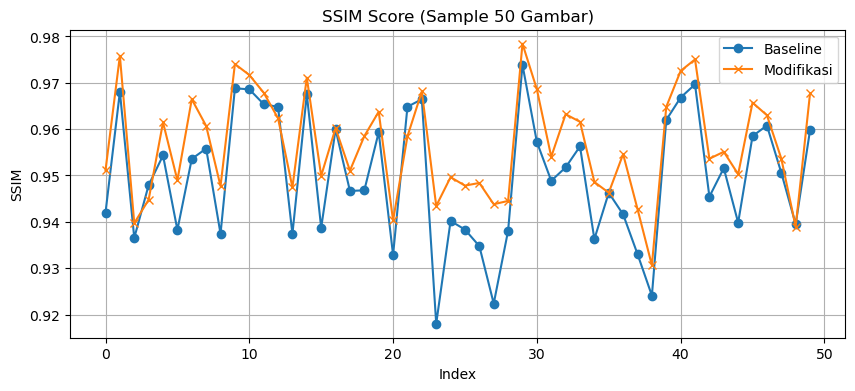

In [316]:
plt.figure(figsize=(10,4))
plt.plot(ssim_baseline[:50], label='Baseline', marker='o')
plt.plot(ssim_modifikasi[:50], label='Modifikasi', marker='x')
plt.title('SSIM Score (Sample 50 Gambar)')
plt.xlabel('Index')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)
plt.show()

In [270]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# atau
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Using GPU:", tf.test.is_gpu_available())


TensorFlow version: 2.18.0
GPU available: []
Built with CUDA: False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using GPU: False


In [272]:
pip show tensorflow


Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\ASUS\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.
